In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline

# Some additional libraries which we'll use just
# to produce some visualizations of our training
from libs.utils import montage
from libs import gif
import IPython.display as ipyd
plt.style.use('ggplot')

# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

## Use Autoencoders   -- unsurprised

- An autoencoder is a type of neural network that learns to encode its inputs, often using much less data. It does so in a way that it can still output the original input with just the encoded values. For it to learn, it does not require "labels" as its output. Instead, it tries to output whatever it was given as input. So in goes an image, and out should also go the same image. But it has to be able to retain all the details of the image, even after possibly reducing the information down to just a few numbers.
- We'll also explore how this method can be extended and used to cluster or organize a dataset, or to explore latent dimensions of a dataset that explain some interesting ideas. For instance, we'll see how with handwritten numbers, we will be able to see how each number can be encoded in the autoencoder without ever telling it which number is which.

#### Read mnist data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist= input_data.read_data_sets('../data/mnist/',one_hot=True)

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


Label:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


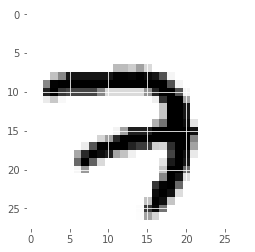

In [3]:
## take a look at the first image
i = mnist.train.images[0].reshape(28,28)
plt.imshow(i,cmap='Greys')
print('Label: ',mnist.train.labels[0])

In [ ]:
## take a look at firt 1000 images
imgs = mnist.train.images[:400].reshape(-1,28,28)  ## unflaten 2d to 3d
plt.imshow(montage(imgs),cmap='gray')              ## montage function is defined
                                                   ## in utility 

#### Take a look at mean and standard deviation

In [ ]:
# Take the mean across all images
mean_img = np.mean(imgs, axis=0)
plt.imshow(mean_img, cmap='gray')

In [ ]:
# Take the mean across all images
std_img = np.std(imgs, axis=0)
plt.imshow(std_img)

##### Now we can see, actually only the central part of the image chages, pixels on the edges does not really matter

####  We will started with fully connected model 

To try and encode our dataset, we are going to build a series of fully connected layers that get progressively smaller. So in neural net speak, every pixel is going to become its own input neuron. And from the original 784 neurons, we're going to slowly reduce that information down to smaller and smaller numbers. It's often standard practice to use other powers of 2 or 10. I'll create a list of the number of dimensions we'll use for each new layer.

<img src='pic/autoencoder_0.png',height=400, width = 900>

In [4]:
dimensions = [512, 256, 128, 64]             # reduce the feature thourgh each layer
n_features = mnist.train.images.shape[1]     # training set is a matrix, each row is a picture, with 784 pixels 
X = tf.placeholder(tf.float32, [None, n_features])  # first dimention is none, to make it flexible

In [5]:
##building the encoding network ###
##################################
current_input = X
n_input = n_features
Ws = []           # We're going to keep every matrix we create so let's create a list to hold them all

# We'll create a for loop to create each layer, this is the same as we did in previous session:
for layer_i, n_output in enumerate(dimensions):
    with tf.variable_scope("encoder/layer/{}".format(layer_i)): ## put each layer in scopes
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        h = tf.matmul(current_input, W)
        current_input = tf.nn.relu(h)
        Ws.append(W)    # Finally we'll store the weight matrix so we can build the decoder.
        n_input = n_output  ## change the dimension, make n_input to be n_output for next iteration

[784, 512]
[512, 256]
[256, 128]
[128, 64]


In [7]:
##building the decoding network ###
##################################

Ws = Ws[::-1]      # We'll first reverse the order of our weight matrices
dimensions = dimensions[::-1][1:] + [ds.X.shape[1]] # then reverse the order of our dimensions
print(dimensions)                                   # appending the last layers number of inputs.

for layer_i, n_output in enumerate(dimensions):
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):

        # Now we'll grab the weight matrix we created before and transpose it
        # So a 3072 x 784 matrix would become 784 x 3072
        # or a 256 x 64 matrix, would become 64 x 256
        W = tf.transpose(Ws[layer_i])

        # Now we'll multiply our input by our transposed W matrix
        h = tf.matmul(current_input, W)

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

In [9]:
dimensions[::-1]

[64, 128, 256, 512]